Below takes a patient probe_reads file and outputs likelihood of PCR swap based on comparison to ground truth cell lines.
This should be pretty generic, although different cell line libraries could be used depending how saturated patient sequencing is.
This example is for very saturated libraries

In [1]:
import sys
sys.path.append('/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/src/')
import tools_for_pcr_swap_table as pcr_swap_tools
from gapfill_utilities import utils as gf_utils
from tools_for_pcr_swap_table import sample_and_get_swap_probabilities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Parameters cell (must be tagged as "parameters")
lib = '1'


mkdir: cannot create directory ‘likelihood_tables/’: File exists


568648 UMIs found
Collapsing UMIs across probes, 568648 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 566830 UMIs remaining (99.68%)
Filtering cells based on min counts (0) and genes (0) in WTA
Filtering probe reads based on cell barcodes in adata, 552672 UMIs remaining (97.19%)
674061 UMIs found
Collapsing UMIs across probes, 674061 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 671947 UMIs remaining (99.69%)
Filtering cells based on min counts (0) and genes (0) in WTA
Filtering probe reads based on cell barcodes in adata, 650774 UMIs remaining (96.55%)
522506 UMIs found
Collapsing UMIs across probes, 508389 UMIs remaining (97.30%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 504066 UMIs remaining (96.47%)
Filtering cells based on min counts (0) and genes (0) in WTA
Filtering probe reads based on cell barcodes in adata, 278

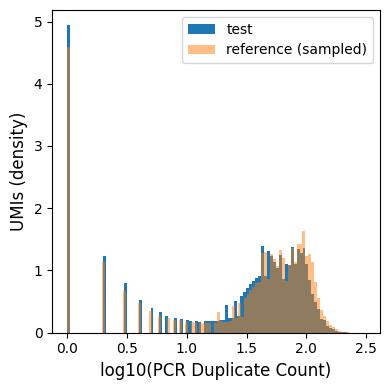

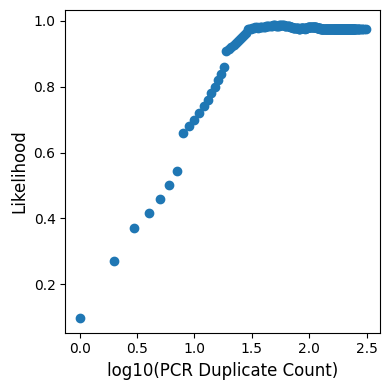

In [ ]:
lib = str(lib)
os.system('mkdir likelihood_tables/')

for BC in ['BC001', 'BC002', 'BC003', 'BC004', 'BC005', 'BC006', 'BC007', 'BC008', 'BC009', 'BC010', 'BC011', 'BC012', 'BC013', 'BC014', 'BC015', 'BC016']:

    ### first get probe_reads to use for the patient

    adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250605_MPN_' + lib + '_' + BC + '.h5ad'

    gf_dirs = {}
    gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    min_percent_supporting = 0.9
    collapse_across_probes = True
    for key,gf_dir in gf_dirs.items():
        if key == 0:
            probe_reads = gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)
        else:
            probe_reads = pd.concat([probe_reads, gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)], ignore_index=True)
    probe_reads_patient = probe_reads.copy()

    patient_min_threshold = 10 ## min_threshold is an inclusive read threshold above obvious background

    ### then use cell line as reference to get probability of a PCR swap based on read count
    ### adjust inputs below as needed
    gf_dir = '/data1/lareauc/users/blattms/gapfill/analysis/giftwrap_runs/JAK2_cell_lines/20241010_LNA_JAK2/giftwrap/'
    adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20241010_GF_LNA_JAK2_WTA.h5ad'
    expected_genotypes_file = '/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/3CL_SUK_168probe_predicted_genotypes.csv'

    probe_reads_cl = gf_utils.get_input_probe_reads(gf_dir, read_threshold=0, min_percent_supporting=0.9, adata_path=adata_path, collapse_across_probes=True)

    cl_min_threshold = 10 ## min_threshold is an inclusive threshold above obvious background

    ### now sample the cell line distribution and get probability of pcr swaps for the patient
    ### plots are output for sanity checks
    prob_real = sample_and_get_swap_probabilities(probe_reads_patient, probe_reads_cl, patient_min_threshold, cl_min_threshold, expected_genotypes_file)

    prob_real.to_csv('likelihood_tables/patient_' + BC + '_swap_probabilities.csv', index=True)